<div style="border:solid green 2px; padding: 20px">

Описание проекта.
    
Задача: провести анализ оттока клиентов «Метанпромбанк»:
1) Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2) Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3) Проанализировать основные признаки, наиболее сильно влияющие на отток;
4) Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    
    4.1. Выделить целевые группы клиентов;
    
    4.2. Предложить меры по снижению оттока;
    
    4.3 Определить другие особенности взаимодействия с клиентами.

Описание датасета bank_scrooge:
- `USERID` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — количество баллов собственности
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `EST_SALARY` — оценочный доход клиента,
- `сhurn` — признак оттока.ак оттока.

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
from scipy import stats as st
from scipy.stats import shapiro # для проведения теста Шапиро - Уилка
from scipy.stats import mannwhitneyu # для проведения теста Манна - Уитни
from statsmodels.stats.proportion import proportions_ztest # для проведения z-теста
from scipy. stats import lognorm
import statsmodels.api as sm

## Предобработка данных

In [2]:
#открыть датасет (bank_scrooge)
try:
    bank_scrooge = pd.read_csv('/datasets/bank_scrooge.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/bank_scrooge.csv')

### Проверка корректности наименования столбцов

In [3]:
#ознакомиться с bank_scrooge
bank_scrooge.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
#уйдем от "научной нотации" для отображения числовых значений
pd.options.display.float_format = '{:.3f}'.format 

In [5]:
# приведем наименования столбцов к единому формату
bank_scrooge.rename(columns = {'USERID':'user_id', 'EST_SALARY':'est_salary'}, inplace = True )

### Типы данных и обработка пропусков

In [6]:
#общая информация о bank_scrooge
bank_scrooge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [7]:
#количество впропусков в записях
bank_scrooge.isnull().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

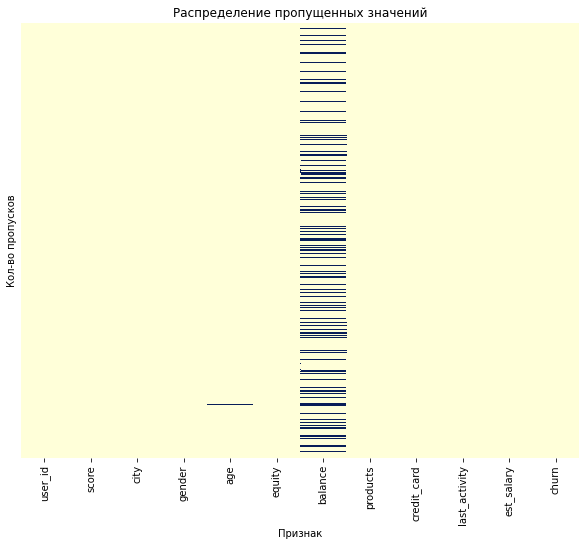

In [8]:
#визуализация пропусков

plt.figure(figsize=(10, 8))
sns.heatmap(bank_scrooge.isna(), yticklabels=False, cbar=False, cmap="YlGnBu")

plt.xlabel('Признак')  # подпись оси х
plt.ylabel('Кол-во пропусков')  # подпись оси у
plt.title('Распределение пропущенных значений')  # подпись названия

plt.show()

In [9]:
#цикл для отображения доли пропусков
for col in bank_scrooge.columns:
    pct_missing = np.mean(bank_scrooge[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

user_id - 0%
score - 0%
city - 0%
gender - 0%
age - 0%
equity - 0%
balance - 23%
products - 0%
credit_card - 0%
last_activity - 0%
est_salary - 0%
churn - 0%


In [10]:
#посмотрим на пропуски непосредственно
bank_scrooge[bank_scrooge['age'].isna()]['age'].unique()

array([nan])

**Вывод:** доля пропусков крайне мала - удалим пропуски в столбце возраст ('age')

In [11]:
# удаление пропусков в столбце возраст ('age'), так как доля пропусков крайне мала 
bank_scrooge.dropna(axis = 'index', subset = ['age'], inplace = True)

# убедимся, что действительно не осталось пропусков
bank_scrooge ['age'].isna().sum()

0

In [12]:
# приведем тип данных столбца возраст к типу int64
bank_scrooge['age'] = bank_scrooge['age'].astype(int) 

In [13]:
#попробуем понять причину отсутствия данных о балансе на счету (случайно ли упущены данные?) 
# сгруппируем по столбцу 'balance', где True - отсутствуют данные; False - значение заполнено
bank_scrooge.groupby(bank_scrooge['balance'].isnull()).mean().style.background_gradient(axis = 1)

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
balance,,,,,,,,,,
False,171710.892268,843.744120,42.924366,3.394802,827245.587515,2.081222,0.640156,0.515140,124520.394264,0.234698
True,171904.885915,865.357174,42.093023,0.051338,nan,1.163229,0.815270,0.548925,226345.417464,0.005704


**Вывод:**
наиболее сильная разница по параметрам: 
- кол-во баллов собственности;
- кол-во используемых клиентом продуктов банка: клиенты, в записях которых содержатся пропуска пользуются меньшим числом продуктов банка;
- оценочный доход клиента: клиенты, в записях которых содержатся пропуска имеют чуть более высокий уровень заработной платы;

In [14]:
# посмотрим связаны ли пропуски в столбце balance с фактом оттока:
bank_scrooge[bank_scrooge['balance'].isna()]['churn'].value_counts()

0    2266
1      13
Name: churn, dtype: int64

**Вывод:**
В 12 случаях пропуск мог быть связан с тем, что клиент ушел из банка.

In [15]:
#посмотрим на пропуски непосредственно
bank_scrooge[bank_scrooge['balance'].isna()]['balance'].unique()

array([nan])

**Вывод:**
Имеющиеся пропуски  - NaN. Данный тип значений относится к вещественным числам, float. NaN можно использовать в математических операциях, не вызывая ошибку из-за несовместимых типов.
Так как доля таких пропусков во всем датасете значительна (23%), удалить данные записи нельзя. Заполнить их каким-либо расчетным значением тоже не корректно. Следует также отметить, что сложно себе представить ситуацию, когда у банка нет данных о балансе (остатке денежных средств на счету клиента).
По моему мнению они относятся к категории MNAR (Missing Not At Random / Отсутствует не случайно). Учитывая вышеизложенное нужно оставить пропуски как есть.  

### Поиск дубликатов

In [16]:
# поиск дубликатов
print('Дубликатов:', bank_scrooge.duplicated().sum())

Дубликатов: 0


In [17]:
# поиск дубликатов по столбцам с уникальными значениями
print('Дубликатов по столбцу идентификатор пользователя:', bank_scrooge['user_id'].duplicated().sum())

Дубликатов по столбцу идентификатор пользователя: 50


In [18]:
bank_scrooge['user_id'].value_counts()

120258    2
217643    2
199312    2
170312    2
200863    2
         ..
181682    1
179637    1
173494    1
175543    1
215039    1
Name: user_id, Length: 9924, dtype: int64

In [19]:
duplicateRows = bank_scrooge[bank_scrooge.duplicated(['user_id'])]
duplicateRows

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1583,190253,726.000,Ярославль,М,49,0,NaN,1,1,1,177700.780,0
1837,210662,896.000,Рыбинск,Ж,37,0,NaN,2,0,0,90916.040,0
2138,131419,739.000,Рыбинск,Ж,37,3,1307941.650,3,0,0,103867.470,0
2302,220816,934.000,Рыбинск,Ж,74,5,1294285.390,3,1,0,95606.800,0
2998,208081,821.000,Рыбинск,Ж,62,3,493608.260,2,1,1,33491.450,0
3039,170312,813.000,Рыбинск,Ж,47,3,370027.670,2,0,0,129835.560,0
3106,185748,912.000,Ярославль,Ж,47,5,1598218.980,2,0,0,180256.980,0
3817,211130,918.000,Рыбинск,Ж,55,0,NaN,2,1,1,244202.040,0
4186,217643,804.000,Рыбинск,Ж,40,2,301836.650,2,1,1,81137.220,0
4216,226719,903.000,Рыбинск,Ж,63,0,NaN,1,1,0,138582.580,0


In [20]:
# посмотрим как распределены эти записи по городам присутствия банка
duplicateRows.groupby(['city', 'est_salary']).count()

user_id  score  gender  age  equity  balance  products  \
city      est_salary                                                           
Рыбинск   28843.540         1      1       1    1       1        0         1   
          32835.450         1      1       1    1       1        1         1   
          33491.450         1      1       1    1       1        1         1   
          45608.450         1      1       1    1       1        1         1   
          46055.320         1      1       1    1       1        1         1   
          46147.060         1      1       1    1       1        1         1   
          49400.370         1      1       1    1       1        1         1   
          54049.880         1      1       1    1       1        1         1   
          64351.810         1      1       1    1       1        1         1   
          69622.580         1      1       1    1       1        1         1   
          79963.590         1      1       1    1       1        1         1   
          81100.600         1      1       1    1       1        1         1   
          81137.220         1      1       1    1       1        1         1   
          90916.040         1      1       1    1       1        0         1   
          95606.800         1      1       1    1       1        1         1   
          100197.670        1      1       1    1       1        1         1   
          103867.470        1      1       1    1       1        1         1   
          118052.840        1      1       1    1       1        0         1   
          118465.340        1      1       1    1       1        0         1   
          120296.600        1      1       1    1       1        0         1   
          124786.530        1      1       1    1       1        0         1   
          129015.250        1      1       1    1       1        1         1   
          129835.560        1      1       1    1       1        1         1   
          138582.580        1      1       1    1       1        0         1   
          148336.260        1      1       1    1       1        1         1   
          152189.720        1      1       1    1       1        0         1   
          244202.040        1      1       1    1       1        0         1   
          255296.470        1      1       1    1       1        1         1   
          291619.270        1      1       1    1       1        0         1   
Ярославль 53099.160         1      1       1    1       1        1         1   
          56971.910         1      1       1    1       1        1         1   
          71211.660         1      1       1    1       1        1         1   
          71816.860         1      1       1    1       1        1         1   
          83955.650         1      1       1    1       1        0         1   
          96173.480         1      1       1    1       1        0         1   
          97545.360         1      1       1    1       1        1         1   
          103314.920        1      1       1    1       1        1         1   
          116500.810        1      1       1    1       1        1         1   
          119247.610        1      1       1    1       1        0         1   
          120356.440        1      1       1    1       1        1         1   
          121371.730        1      1       1    1       1        1         1   
          137718.930        1      1       1    1       1        0         1   
          138403.600        1      1       1    1       1        1         1   
          146427.960        1      1       1    1       1        0         1   
          166845.370        1      1       1    1       1        0         1   
          177700.780        1      1       1    1       1        0         1   
          180256.980        1      1       1    1       1        1         1   
          188054.460        1      1       1    1       1        1         1   
          261904.440  

**Вывод:** 
1) дубликаты user_id есть только в 2х городах (Рябинск, Ярославль) из 3х (нет в Ростове). При этом значения в столбце оценочный доход клиента ('est_salary') не дублируются, то есть скорее всего клиенты разные.

2) в банковской системе бывает, что у разных филиалов разные базы данных, в таком случае вполне возможно дублирование идентификатора пользователя ('user_id').

Резюмируя считаю, что можно оставить данные записи, так как для результат анализа - выделение сегмента, группы клиентов.

In [21]:
bank_scrooge.drop('user_id', axis= 1 , inplace= True )

In [22]:
#изучение данных в столбце 'city'; проверка на наличие дубликатов
bank_scrooge['city'].value_counts()

Ярославль    5875
Рыбинск      2683
Ростов       1416
Name: city, dtype: int64

**Вывод:**
3 города, как и должно быть

In [23]:
#изучение данных в столбце 'gender'; проверка на наличие дубликатов
bank_scrooge['gender'].value_counts()

М    4991
Ж    4983
Name: gender, dtype: int64

**Вывод:**
2 пола, как и должно быть

In [24]:
#изучение данных в столбце 'credit_card'; проверка на наличие дубликатов
bank_scrooge['credit_card'].value_counts()

1    6784
0    3190
Name: credit_card, dtype: int64

In [25]:
#изучение данных в столбце 'last_activity'; проверка на наличие дубликатов
bank_scrooge['last_activity'].value_counts()

1    5215
0    4759
Name: last_activity, dtype: int64

In [26]:
#изучение данных в столбце 'churn'; проверка на наличие дубликатов
bank_scrooge['churn'].value_counts()

0    8155
1    1819
Name: churn, dtype: int64

<div style="border:solid green 2px; padding: 20px">
    
**Выводы по этапу Предобратока данных:**
1) для единообразия названия столбцов приведены к нижнему регистру;
    
2) не обнаружено полностью идентичных записей, однако, обнаружены дубликаты в столбце идентификатор пользователя ('user_id'). Принято решение оставить данные записи;
    
3) типы данных столбцов, в целом, корректны. Данные в столбце возраст приведены к типу int32, так как нас интересует полное кол-во лет и чаще всего именно полное кол-во лет отображается (без .0).
    
4) общий объем датасета - 10 000 строк. Из них пропуски есть в 2х столбцах:
   - возраст (26 пропущенных значений);
   - баланс на счете (2 295 пропущенных значений);
    
5) удалены строки с пропуском в столбце 'возраст';
    
6) пропуски в столбце 'баланс на счете' оставлены без изменений: определено, что данные пропуски это Nan значения, которые можно использовать в математических операциях. Также крайне не понятно как в банке может не быть информации о балансе клиента (то есть не ясна природа этих пропусков и заполнять их каким-либо расчетными значениями неверно). По моему мнению они относятся к категории MNAR (Missing Not At Random / Отсутствует не случайно).   
    
</div>

## Исследовательский анализ данных

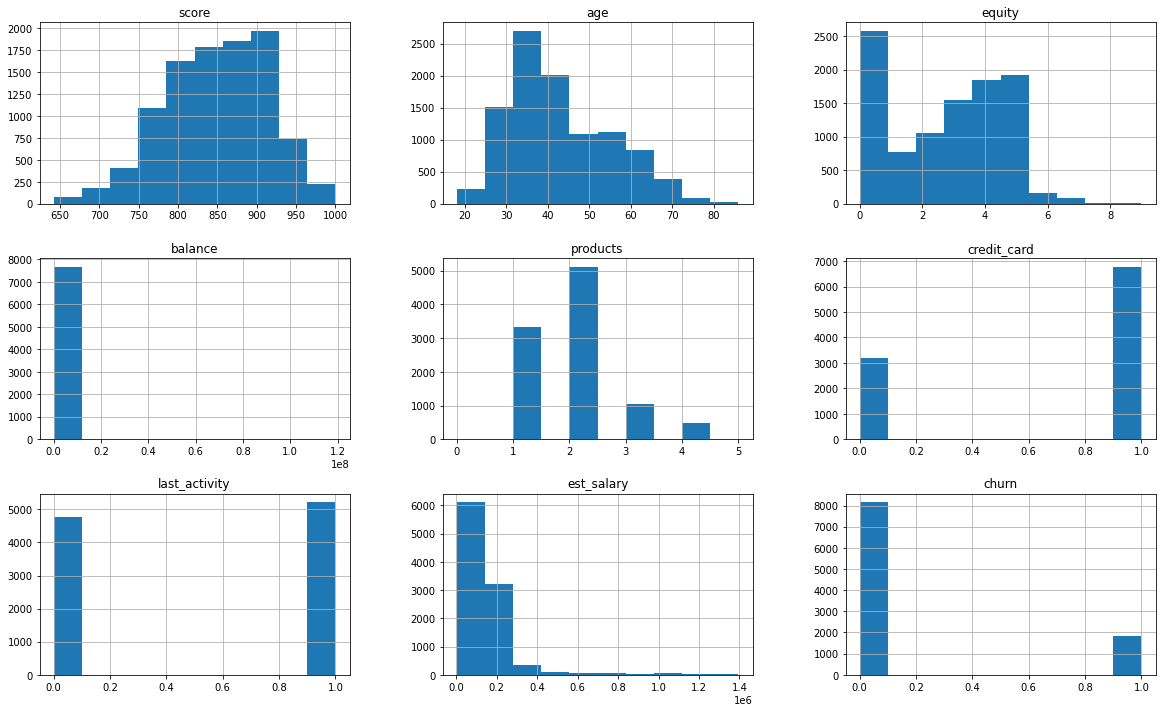

In [27]:
#визуализация распределения признаков, общее знакомство
bank_scrooge.hist(figsize=(20,12));

**Выводы:**
- `score` — баллы кредитного скоринга: скошенное распределение (отрицательная ассиметрия)
- `age` — возраст: смещение вправо, положительная ассиметрия
- `equity` — количество баллов собственности: 2 пика: чаще встречается 0 оценка и далее уже росто от 2х баллов.
- `balance` — баланс на счёте: мы знаем, что есть 23% пропусков (Nan) и, очевидно, много значений баланса клиентов близких к 0.
- `products` — количество продуктов, которыми пользуется клиент: 5 типов продуктов, с учетом удаленной записи с 0 значением - 4ре пика, ожидаемо.
- `credit_card` — есть ли кредитная карта:бинарные данные, отсюда просто 2 пика. ожидаемо.
- `last_activity` — активный клиент:бинарные данные, отсюда просто 2 пика. ожидаемо.
- `est_salary` — оценочный доход клиента: смещение вправо, положительная ассиметрия. Чаще встречается низкий уровень оценочного дохода клиента, что ожидаемо.
- `сhurn` — признак оттока: бинарные данные, отсюда просто 2 пика. ожидаемо.

In [28]:
# изучение данных
bank_scrooge.describe()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9974.000,9974.000,9974.000,7695.000,9974.000,9974.000,9974.000,9974.000,9974.000
mean,848.683,42.734,2.631,827245.588,1.871,0.680,0.523,147786.810,0.182
std,65.400,12.180,1.980,1980327.410,0.793,0.466,0.500,139285.514,0.386
min,642.000,18.000,0.000,0.000,0.000,0.000,0.000,2546.300,0.000
25%,802.000,33.000,0.000,295698.715,1.000,0.000,0.000,75251.660,0.000
50%,853.000,40.000,3.000,524295.330,2.000,1.000,1.000,119626.795,0.000
75%,900.000,51.000,4.000,980051.215,2.000,1.000,1.000,174499.812,0.000
max,1000.000,86.000,9.000,119113552.010,5.000,1.000,1.000,1395064.450,1.000


**Выводы:**
1) в столбце products минимальное значение  = 0, то есть клиент банка не имеет ни одного продукта этого банка. А такое невозможно, необходимо понять причину такого минимального значения. При этом максимально кол-во банковских продуктов клиента = 5;

2) клиенты банка люди в возрасте от 18 до 86 лет; Средний возраст составляет 42 года

3) средний показатель в столбце оценочный доход клиента ('est_salary') составляет 147 866,88, при этом максимальное значение 1 395 064.45 - вероятно тут есть аномалии/выбросы (мы рассматриваем региональный банк, там маловероятны клиенты с таким уровнем дохода); нужно посмотреть, возможно искл. из датасета.

4) средний показатель в столбце баланс на счёте ('balance') составляет 827 794.307, при этом максимальное значение 119 113 552.010. Возможно среди клиентов есть очень состоятельные люди, но все равно есть смысл посмотреть внимательнее.	

In [29]:
# посмотрим на стороку, где значение в столбце 'products' = 0
bank_scrooge[bank_scrooge['products']==0]

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,962.000,Рыбинск,Ж,79,3,NaN,0,0,0,25063.960,1


Видимо данный клиент уже не является активным, так как last_activity имеет значение 0.

In [30]:
#удаление данных, где значение в графе количество продуктов, которыми пользуется клиент ('priducts') = 0
bank_scrooge = bank_scrooge[bank_scrooge['products']!=0]

### Выбросы, аномальные значения

In [31]:
#цикл для расчет IQR и пределов/границ выбросов
for x in ['score', 'balance', 'est_salary' ]:
    IQR = st.iqr(bank_scrooge[x], interpolation = 'midpoint', nan_policy='omit')
    Q1 = np.percentile(bank_scrooge[x], 25 , interpolation = 'midpoint' )
    Q3 = np.percentile(bank_scrooge[x], 75 , interpolation = 'midpoint' )
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    print(x, ' '*(15-len(x)),  'IQR =', IQR)
    print(' '*15, 'нижняя граница =', low_lim)
    print(' '*15, 'верхняя граница =', up_lim)
    print()

score            IQR = 98.0
                нижняя граница = 655.0
                верхняя граница = 1047.0

balance          IQR = 684352.5
                нижняя граница = nan
                верхняя граница = nan

est_salary       IQR = 99247.93999999999
                нижняя граница = -73619.88999999997
                верхняя граница = 323371.87



**Вывод**: все значения набора данных, которые отклоняются от медианы больше, чем на 3IQR, считаются выбросами

In [32]:
# посмотрим строки, где значение оценочного дохода клиента 'est_salary' > 3*323 374.625 + 147 866.886 = 1 117 990,761
bank_scrooge.query('est_salary > 1117990')

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
149,958.000,Ярославль,М,34,0,NaN,1,1,0,1292825.740,0
178,890.000,Ярославль,М,49,4,3956103.100,2,1,0,1120528.700,0
302,942.000,Ярославль,М,40,0,NaN,1,1,0,1256537.740,0
663,949.000,Ярославль,М,45,0,NaN,1,1,0,1142166.480,0
1027,1000.000,Ярославль,М,50,5,12909691.020,1,1,0,1253653.400,0
1468,940.000,Ярославль,М,32,2,4508306.650,2,1,0,1260919.560,0
1600,785.000,Ярославль,М,41,0,NaN,1,1,0,1307090.180,0
1814,718.000,Ярославль,М,25,0,NaN,1,1,1,1180070.170,0
2291,980.000,Ярославль,Ж,35,6,1813817.400,2,1,1,1130928.150,0
2424,941.000,Ярославль,М,35,0,NaN,1,1,0,1121684.220,0


In [33]:
#сгруппируем по количеству баллов собственности ('equity')
bank_scrooge.query('est_salary > 1117990').groupby(['equity']).count()

,score,city,gender,age,balance,products,credit_card,last_activity,est_salary,churn
equity,,,,,,,,,,
0,14,14,14,14,0,14,14,14,14,14
2,1,1,1,1,1,1,1,1,1,1
4,2,2,2,2,2,2,2,2,2,2
5,6,6,6,6,6,6,6,6,6,6
6,1,1,1,1,1,1,1,1,1,1


**Вывод:**
Нет доверия к сотрудникам банка «Метанпром» в городе Ярославль:
из 24х записей о клиентах, чей доход более 1 117 990,00 у 14ти записей нет данных о балансе, количество баллов собственности ('equity') = 0 (то есть нет информации о собственности клиента); всего лишь 1 банковский продукт чаще всего. 

Все это ... странно. 

In [34]:
pd.pivot_table(bank_scrooge[['credit_card', 'equity', 'last_activity', 'city', 'products', 'churn']],
               index = ['city', 'products'],
               values=['churn'],
               aggfunc = [np.mean] # узнаем среднее значение
              ).style.background_gradient(axis = 1) # форматирование

### Портрет клиента

In [35]:
# Создадим сводную таблицу для отображение мер центральной тенденции по некоторым из параметров
table_1 = pd.pivot_table(bank_scrooge, 
                           values=['balance','est_salary', 'score','age','equity','products','city', 'gender'],
                           index=['churn'],
                           aggfunc={'balance': 'mean', 'est_salary':'mean',
                                    'score': 'mean', 'age':'mean',
                                    'equity':np.median, 'products':np.median}).T
table_1['% (delta)'] = ((table_1[1]/table_1[0]) - 1) * 100

In [36]:
# Создадим сводную таблицу для категориальных признаков
table_mode = pd.pivot_table(bank_scrooge, values=['city', 'gender','last_activity','credit_card'], 
                index=['churn'], aggfunc={
                'city':st.mode, 'gender':st.mode,
                'last_activity':st.mode, 'credit_card':st.mode}).T
table_mode['% (delta)'] = 0

/opt/conda/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:1160: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  f = lambda x: func(x, *args, **kwargs)
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


In [37]:
pd.concat([table_1,table_mode])

churn,0,1,% (delta)
age,43.021,41.430,-3.699
balance,733031.630,1134458.209,54.763
equity,3.000,4.000,33.333
est_salary,147674.638,148357.483,0.462
products,2.000,2.000,0.000
score,845.396,863.362,2.125
city,"([Ярославль], [4758])","([Ярославль], [1117])",0.000
credit_card,"([1], [5781])","([1], [1003])",0.000
gender,"([Ж], [4347])","([М], [1183])",0.000
last_activity,"([0], [4217])","([1], [1277])",0.000


### Кодировка данных (город, пол)

In [38]:
bank_scrooge_dummy = bank_scrooge.copy()
bank_scrooge_dummy['gender_origin'] = bank_scrooge_dummy['gender'] # оставим этот слобец он далее понадобится
# применим функцию к столбцу пол ('gender')
bank_scrooge_dummy = pd.get_dummies(bank_scrooge_dummy, columns = ['gender'],
               prefix = '',
               prefix_sep = '')

In [39]:
# полностью предобработанные данные запишем в переменную df 
df = bank_scrooge_dummy.copy()
df['city_origin'] = df['city'] # оставим этот слобец он далее понадобится

# применим функцию к столбцу город ('city')
df = pd.get_dummies(df, columns = ['city'],
                    prefix = '',
                    prefix_sep = '',
                    drop_first = False)

# приведем наименования столбцов к единому формату
df.rename(columns = {'Ростов':'rostov', 'Рыбинск':'rubinsk', 'Ярославль':'yaroslavl', 'Ж':'female', 'М':'male'}, inplace = True )

In [40]:
# проверка
df.head()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_origin,female,male,city_origin,rostov,rubinsk,yaroslavl
0,850.000,25,1,59214.820,2,0,1,75719.140,1,Ж,1,0,Рыбинск,0,1,0
1,861.000,37,5,850594.330,3,1,0,86621.770,0,Ж,1,0,Рыбинск,0,1,0
2,892.000,30,0,NaN,1,1,1,107683.340,0,Ж,1,0,Рыбинск,0,1,0
3,866.000,51,5,1524746.260,2,0,1,174423.530,1,Ж,1,0,Ярославль,0,0,1
4,730.000,34,5,174.000,1,1,0,67353.160,1,М,0,1,Ярославль,0,0,1


### Распределение признаков

In [41]:
# посчитаем % оттока от числа клиентов по городам
cities = bank_scrooge_dummy.groupby('city')\
  .agg({'churn': 'mean'})\
  .sort_values(by='churn', ascending=False)\
  .rename(columns={'churn': '% оттока'})\
  .style.format({'% оттока': '{:.2%}'})\

cities

,% оттока
city,
Ярославль,19.01%
Ростов,18.71%
Рыбинск,16.26%


**Вывод:**
Больше всего ушло клиентов из Ярославля (19,02%); Ростов (18,77%); Рыбинск (16,18%)

In [42]:
#доля оттока по продукту через pivot_table()
outflow_share = bank_scrooge_dummy.pivot_table(index='products',
                                               values='churn',
                                               aggfunc=['count', 'sum', 'mean']).sort_values(by=('mean', 'churn'))  # сортировка по % оттока
outflow_share.columns = ['Общее количество клиентов', 'Количество ушедших клиентов', '% оттока']
outflow_share_formatted = outflow_share.style.format({'% оттока': '{:.2%}'})  # применение форматирования
outflow_share_formatted

,Общее количество клиентов,Количество ушедших клиентов,% оттока
products,,,
1,3323,235,7.07%
2,5119,978,19.11%
3,1038,297,28.61%
5,19,8,42.11%
4,474,300,63.29%


**Вывод:**
В порядке убывания:
- 4ре продукта - отток 63,29%;
- 5 продуктов - отток 42,11%;
- 3 продукта - 28,59%
- 2 продукта - 19,11%
- 1 продукт - 7,06%

In [43]:
#доля оттока по количествe баллов собственности через pivot_table()
equity_share = bank_scrooge_dummy.pivot_table(index = 'equity', 
                               values = 'churn',
                               aggfunc = ['count', 'sum', 'mean']).sort_values(by=('mean', 'churn')) # сортировка по % оттока
equity_share.columns = ['Общее количество клиентов', 'Количество ушедших клиентов', '% оттока']
equity_share_formatted = equity_share.style.format({'% оттока': '{:.2%}'})  # применение форматирования
equity_share_formatted

,Общее количество клиентов,Количество ушедших клиентов,% оттока
equity,,,
0,2576,90,3.49%
1,773,93,12.03%
2,1051,166,15.79%
3,1540,321,20.84%
4,1847,464,25.12%
5,1915,576,30.08%
8,17,6,35.29%
6,161,58,36.02%
7,80,37,46.25%


**Вывод:** % оттока растет по мере увеличения кол-ва баллов собственности, однако, следует отметить, что и кол-во клиентов значимо сокращается начиная с 8ми баллов собственности. Отсюда и больший %.

Посмотрим распределение признаков

In [44]:
# список с бинарными значениями
features = [
    'products', 'credit_card', 'last_activity', 'churn', 'female', 'male', 'rostov', 'rubinsk', 'yaroslavl' 
    ]

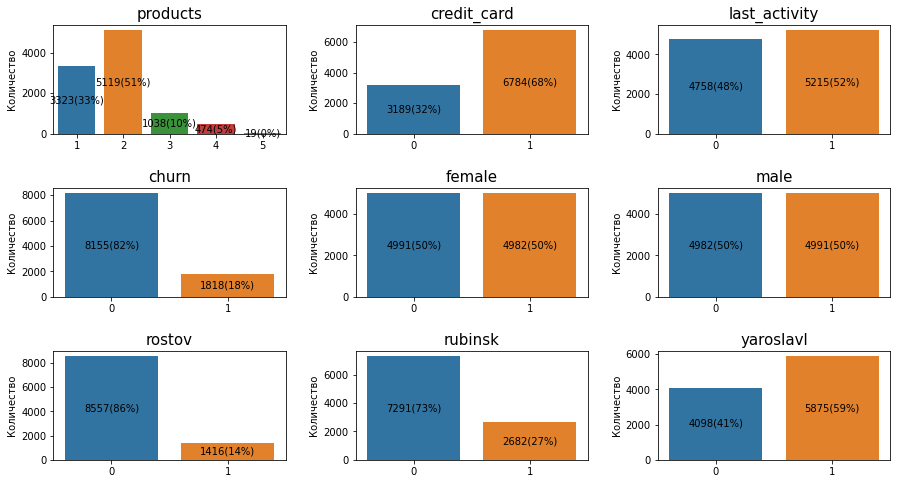

In [45]:
# визуализация
row, col, num_cols = 0, 0, 3
fig, myplot = plt.subplots(figsize = (15,8), nrows = math.ceil(len(features) / num_cols), ncols = num_cols)

for u in features:
    sns.barplot(
        x = df[u].value_counts().index, 
        y = df[u].value_counts(), 
        ax  = myplot[row, col]
    )
    myplot[row, col].set_xlabel("")
    myplot[row, col].set_title(u, fontsize = 15)
    myplot[row, col].set_ylabel("Количество")
    col = col + 1
    if col == num_cols:
        col = 0
        row = row + 1

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.3)

for v in range(row):
    for z in range(num_cols):
        for patch in myplot[v,z].patches:
            label_x = patch.get_x() + patch.get_width()/2  
            label_y = patch.get_y() + patch.get_height()/2
            myplot[v,z].text(label_x, label_y, 
                             str(int(patch.get_height())) + '('+'{:.0%}'.format(
                               patch.get_height()/len(df))+')',
                            horizontalalignment='center', verticalalignment='center')

**Вывод:**
1) по количеству банковских продуктов:(top3)
   - 51% клиентов имеет 2 банковских продукта;
   - 33% клиентов имеет 1 банковский продукт;
   - 10% клиентов имеет 3 банковских продукта;
   
2) кредитная карта есть у 68% клиентов;

3) активность клиентов:
  - 52% активны;
  - 48% не активны;
  
4) **в отток ушло 18% клиентов**;

5) гендерное распределение среди клиентов 50/50;

6) распределение по городам: Ростов (14%), Рыбинск (27%), Ярославль (59%)

### Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался

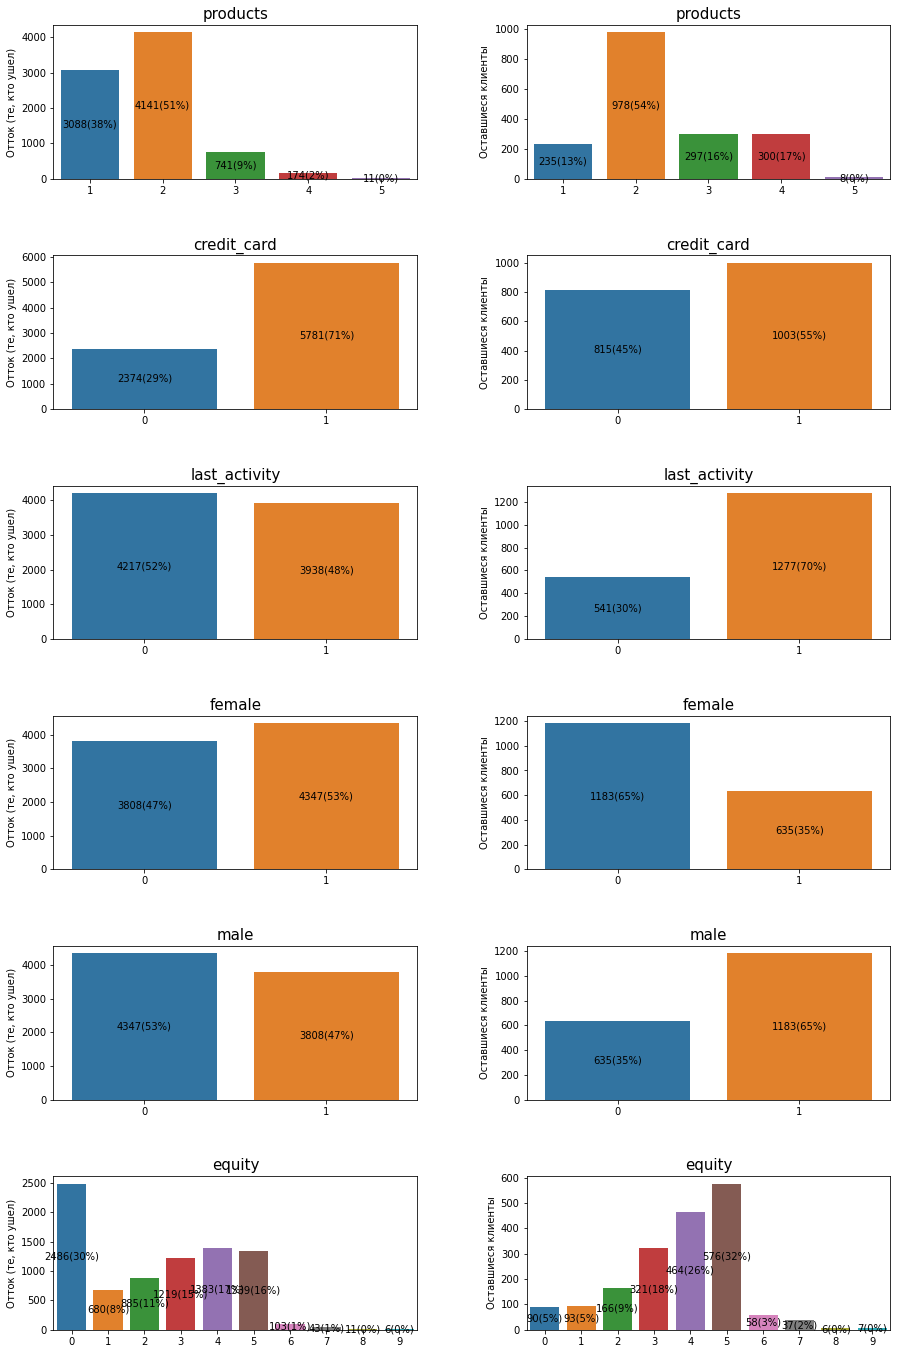

In [46]:
# список 
features_1 = [
    'products', 'credit_card', 'last_activity', 'female', 'male', 'equity' 
    ]

# визуализация
row, col, num_cols = 0, 0, 2
fig, myplot = plt.subplots(figsize = (15, 24), nrows = len(features_1), ncols = num_cols)

for u in features_1:
    for churn in [0, 1]:
        col = churn
        sns.barplot(
            x = df.loc[df['churn']==churn, u].value_counts().index, 
            y = df.loc[df['churn']==churn, u].value_counts(), 
            ax  = myplot[row, col]
        )
        myplot[row, col].set_xlabel("")
        myplot[row, col].set_title(u, fontsize = 15)
        if churn == 0:
            myplot[row, col].set_ylabel("Отток (те, кто ушел)")
        else:
            myplot[row, col].set_ylabel("Оставшиеся клиенты")
    row = row + 1

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.3)
for v in range(row):
    for z in range(num_cols):
        for patch in myplot[v,z].patches:
            label_x = patch.get_x() + patch.get_width()/2  
            label_y = patch.get_y() + patch.get_height()/2
            myplot[v,z].text(label_x, label_y, 
                             str(int(patch.get_height())) + '('+'{:.0%}'.format(
                               patch.get_height()/len(df.loc[df['churn']==z]))+')',
                            horizontalalignment='center', verticalalignment='center')

**Вывод:**

*Общие данные*

|                        |products                          | credit card         |last_activity |
| ---------------------- | -------------------------------- |---------------------|--------------|
|Отток (ушедшие клиенты) | 2 продукта (51%); 1 продукт (38%)|имеют кред. карту 71%|активны 48%   |
|Оставшиеся клиенты      | 2 продукта (54%); 1 продукт (13%)|имеют кред. карту 55%|активны 70%   |


*Гендерное распределение*

|                        |female                  |  male                  |
| ---------------------- | ---------------------- |------------------------|
|Отток (ушедшие клиенты) |53% жен среди ушедших   |47% муж среди ушедших   |
|Оставшиеся клиенты      |35% жен среди оставшихся|65% муж среди оставшихся|

**Итого определено, что в отток ушли:**
- преимущественно женщины;
- клиенты, имеющие кредит.карту;
- клиенты, которые имеют количество баллов собственности = 0  

Первые 3 признака отточных сегментов определены. 

In [47]:
# список числовых признаков
features_nonbool = ['score', 'age', 'balance', 'est_salary'] 

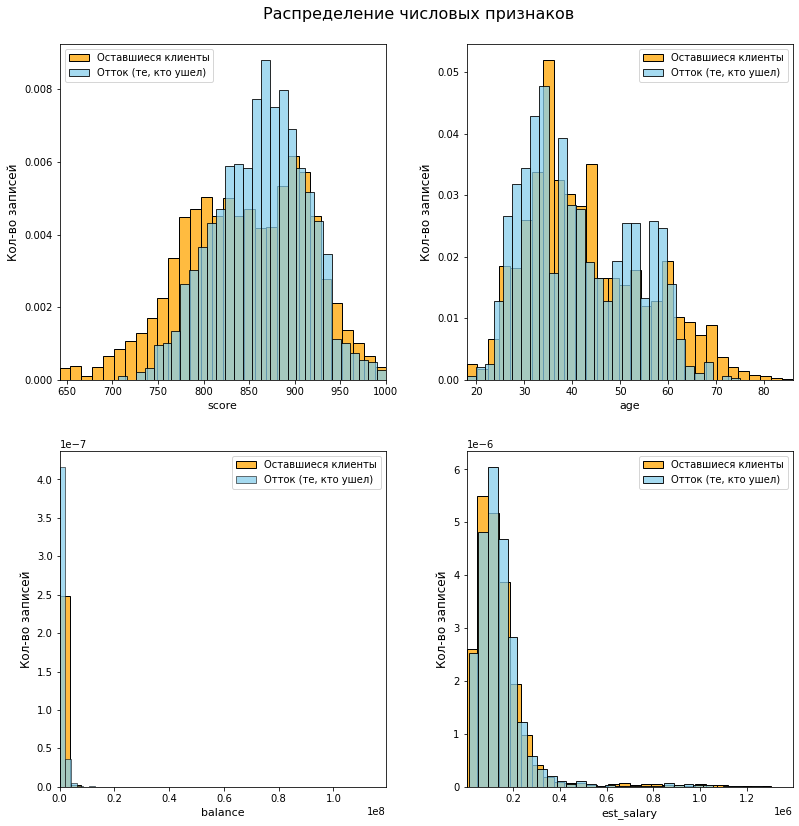

In [48]:
# визуализация распределения числовых признаков
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение числовых признаков', fontsize=16)
for feature in features_nonbool:  # цикл
    ax = axes_list.pop(0)
    sns.histplot(df.query('churn == 0')[feature], bins=30, ax=ax, kde=False, color='orange', stat="density",
                 common_norm=False, label='Оставшиеся клиенты')
    sns.histplot(df.query('churn == 1')[feature], bins=30, ax=ax, kde=False, color='skyblue', stat="density",
                 common_norm=False, label='Отток (те, кто ушел)')
    ax.set_xlabel(feature, fontsize=11)
    ax.set_xlim(left=df[feature].min(), right=df[feature].max()) # установка границ оси x по минимальному и максимальному значению признака
    ax.set_ylabel('Кол-во записей', fontsize=12)
    ax.legend()


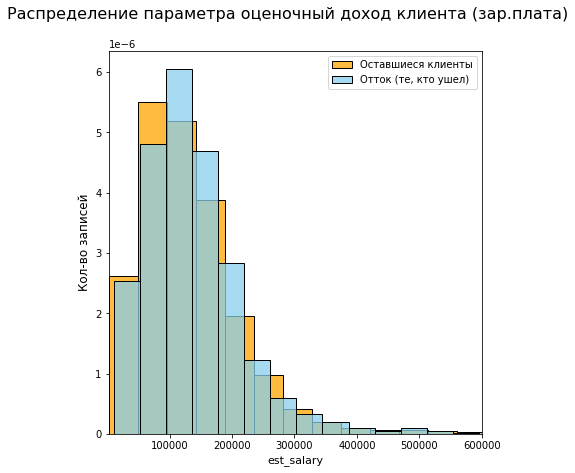

In [49]:
# отдельно посмотрим распределение параметра оценочный доход клиента (зар.плата)
fig, ax = plt.subplots(figsize=(7, 7))
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение параметра оценочный доход клиента (зар.плата)', fontsize=16)
sns.histplot(df.query('churn == 0')['est_salary'], bins=30, ax=ax, kde=False, color='orange', stat="density",
             common_norm=False, label='Оставшиеся клиенты')
sns.histplot(df.query('churn == 1')['est_salary'], bins=30, ax=ax, kde=False, color='skyblue', stat="density",
             common_norm=False, label='Отток (те, кто ушел)')
ax.set_xlabel('est_salary', fontsize=11)
ax.set_xlim(left=df['est_salary'].min(), right=600000)
ax.set_ylabel('Кол-во записей', fontsize=12)
ax.legend();


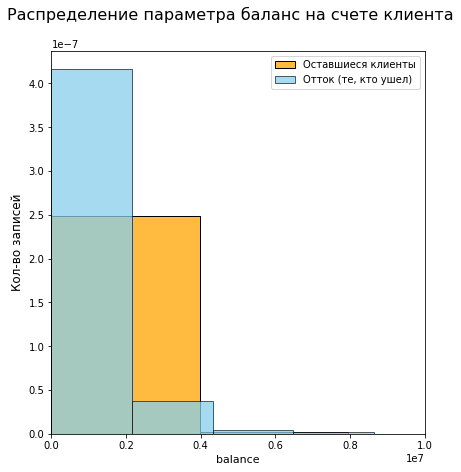

In [50]:
# отдельно посмотрим распределение параметра баланс на счете клиента
fig, ax = plt.subplots(figsize=(7, 7))
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение параметра баланс на счете клиента', fontsize=16)
sns.histplot(df.query('churn == 0')['balance'], bins=30, ax=ax, kde=False, color='orange', stat="density",
             common_norm=False, label='Оставшиеся клиенты')
sns.histplot(df.query('churn == 1')['balance'], bins=30, ax=ax, kde=False, color='skyblue', stat="density",
             common_norm=False, label='Отток (те, кто ушел)')
ax.set_xlabel('balance', fontsize=11)
ax.set_xlim(left=df['balance'].min(), right=10000000)
ax.set_ylabel('Кол-во записей', fontsize=12)
ax.legend();


**Вывод:**

*Общие данные*

|           |Оставшиеся клиенты                                                  |  Отток (ушедшие клиенты)                                                   |
| ----------| ------------------------------------------------------------------ |----------------------------------------------------------------------------|
|score      |выходит на "плато" к 800 ед. больше всего в диапазоне от 800 до 950.| наблюдается пик на 850 - 870 ед. больше всего в диапазоне от 800 до 950.   |
|age        |больше всего клиентов от 35 до 45 лет                               | больше всего клиентов от 25-35, 37-45, 50-60                                      |
|equity     |больше всего клиентов с 0 кол-вом, далее 2й пик - 4 ед.             | среди ушедших клиентов больше всего состоятельных кол-вом баллов от 4 до 5 |
|balance    |много клиентов с небольшим балансом, вкл. пропуска, далее спад      | видимо у ушедших в отток больше всего пропусков                            |
|est_salary |нет сильного различия в уровне дохода у тех кто ушел в отток и тех, кто остался. гистограммы весьма схожи в обеих группах                        |



**Наиболее очевидно, что в отток ушли состоятельные клиенты, с количеством баллов кредитного скорринга от 800 до 950. Возраст от 25 до 35 лет - самая значительная группа и от 50 до 60 вторая по значимости группа клиентов** - вероятно определены 3й и 4й признак отточного сегмента

### Средние значения относительно оттока 

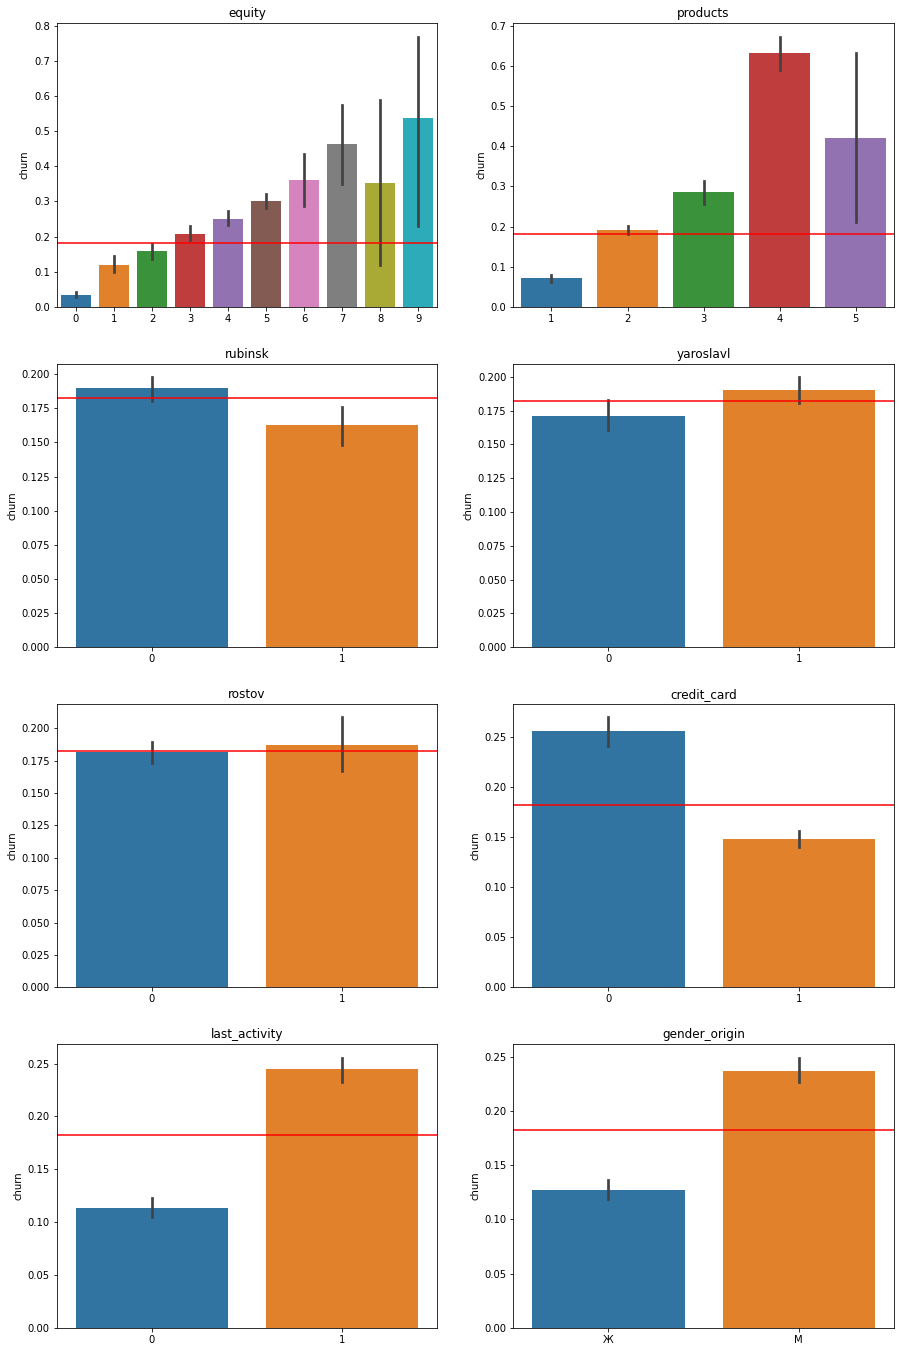

In [51]:
# Построим гистограммы чтобы посмотреть средний уровень оттока по признакам
bools = ['equity', 'products', 'rubinsk', 'yaroslavl', 'rostov', 'credit_card', 'last_activity', 'gender_origin'] 

rows = 4
fig, ax = plt.subplots(nrows=rows, ncols=2, figsize=(15, 24))
ax = ax.flatten()

for i in range(len(bools)):
    sns.barplot(x=df[bools[i]], y='churn', data=df, ax=ax[i])
    ax[i].axhline(y=df['churn'].mean(), c='red', label='Средний показатель оттока') 
    ax[i].set_title(f'{bools[i]}')
    ax[i].set_xlabel('')

plt.show()

**Выводы:**

1) Выше всего отток клиентов в Ярославле, далее в Ростове, после Рыбинск, что в целом подтверждает полученную ранее информацию.

2) Больше отток среди клиентов с высоким количеством баллов собственности и несколькими банковскими продуктами, что в целом объяснимо: люди более заинтересованы в финансовой сфере и в поиске оптимальных банковских продуктов;

### Корреляция признаков

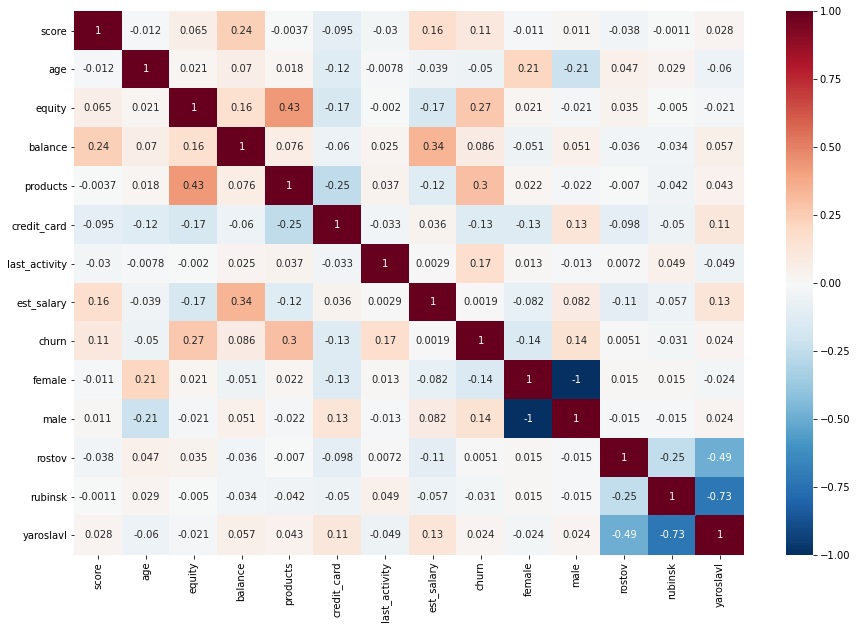

In [52]:
#sns.set(font_scale=1.15)
plt.figure(figsize=(15,10))
sns.heatmap(
    df.corr(), #вычисляем матрицу корреляций        
    cmap='RdBu_r', # задаём цветовую схему
    annot=True, # рисуем значения внутри ячеек
    vmin=-1, vmax=1); # указываем начало цветовых кодов от -1 до 1.

**Выводы:**
1) наиболее сильная положительная кореляция между:
- количеством баллов собственности и количеством продуктов банка ('equity' и 'products') = 0,43: чем состоятельнее клиент, тем больше у него банковскких продуктов;
- уровнем дохода клеиента и балансом его счета ('est_salary' и 'balance') = 0,34: чем больше доход, тем больше счет в банке;
- количеством баллов собственности и оттоком ('equity' и 'churn') = 0,27: получается, что чем больше собственности у клинета банка, тем выше вероятность его оттока.
2) наиболее значимая отрицательная кореляция между:
- наличие/отсутствие кредитной карты и количеством продуктов, которыми пользуется клиент ('credit_card' и 'products') = -0,25;

### Проверка гипотез:

Ранее определено, что на отток влияют:
1) сумма дохода клиента - необходимо проверить гипотезу;
2) количество баллов собственности - необходимо проверить гипотезу;
3) количество продуктов банка - необходимо проверить гипотезу;
4) наличие/отсутствие кредитной карты - необходимо проверить гипотезу;

Проверим применимость t-test (критерия Стьюдента). Именно он применяется для проверки гипотез о равенстве средних значений двух совокупностей - ему отдается приоритет чаще всего. 
Условия применения статистического критерия Стьюдента:
* Генеральные совокупности не должны зависеть друг от друга;
* Выборочные средние должны быть нормально распределены (благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности. Это утверждение верно, даже если сама генеральная совокупность не распределена нормально - наш случай);
* Дисперсии рассматриваемых генеральных совокупностей должны быть равны (допустим, что дисперсии у генеральных совокупностей разные, следовательно, укажим equal_var= False при вызове метода scipy.stats.ttest_ind().

#### Гипотеза №1: Различие суммы дохода оставшихся и отточных клиентов

Сформулируем нулевые гипотезы:

    - H₀: средние доходы оставшихся и отточных клиентов равны
    - H₁: средние доходы оставшихся и отточных клиентов не равны

In [53]:
#посчитаем среднюю оценку для гипотезы №1
print('Средняя оценка по доходу клиентов не в оттоке', df[df['churn'] == 0]['est_salary'].mean())
print('Средняя оценка по доходу клиентов в оттоке', df[df['churn'] == 1]['est_salary'].mean())

Средняя оценка по доходу клиентов не в оттоке 147674.63788105457
Средняя оценка по доходу клиентов в оттоке 148357.48315731573


In [54]:
# проверка с помощью теста Левена
# тест Левана с определением медианы

test_leven, p = st.levene(df[df['churn'] == 0]['est_salary'], df[df['churn'] == 1]['est_salary'], center='median')
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=6.660, p-value=0.010
Отклонить гипотезу о равенстве дисперсий


In [55]:
# проверка с помощью теста Левена
#тест Левана с определением среднего значения

test_leven, p = st.levene(df[df['churn'] == 0]['est_salary'], df[df['churn'] == 1]['est_salary'], center='mean')
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=10.146, p-value=0.001
Отклонить гипотезу о равенстве дисперсий


**Вывод:** 
Тест Левина проверяет нулевую гипотезу о том, что дисперсии равны. По результатом проверки p-value меньше 0,05, следовательно, мы не можем подтвердить нулевую гипотезу и вправе сделать вывод о наличии разницы между дисперсиями.

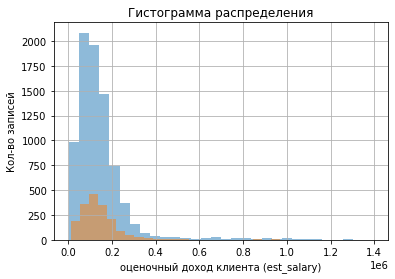

In [56]:
# посмотрим гистограмму распределения
df[df['churn'] == 0]['est_salary'].hist(bins=30, alpha=0.5)
df[df['churn'] == 1]['est_salary'].hist(bins=30, alpha=0.5)
plt.title('Гистограмма распределения')
plt.xlabel('оценочный доход клиента (est_salary)')
plt.ylabel('Кол-во записей');

Применим U-критерий Манна-Уитни для сравнения различий между двумя выборками, так как было установлено, что распределение не является нормальным (результаты тестов + длинный правый хвост на гистограмме)

In [57]:
# применим тест Манна-Уитни
stat, p_value = mannwhitneyu(df[df['churn'] == 0]['est_salary'], df[df['churn'] == 1]['est_salary']) 
print('Statistics=%.2f, p=%.2f' % (stat, p_value)) 
# установим уровень значимости
alpha = 0.05
# выводы
if p_value < alpha: 
    print('Отклонить нулевую гипотезу') 
else: 
    print('Не получилось отклонить нулевую гипотезу')

Statistics=6995242.00, p=0.00
Отклонить нулевую гипотезу


**Вывод:** Отклоняем нулевую гипотезу, то есть средние доходы оставшихся и отточных клиентов не равны.

#### Гипотеза №2: Pазличие количества баллов собственности оставшихся и отточных клиентов

Сформулируем нулевые гипотезы:

    - H₀: средняя оценка баллов собственности оставшихся и отточных клиентов равны
    - H₁: средняя оценка баллов собственности оставшихся и отточных клиентов не равны

In [58]:
#посчитаем среднюю оценку для гипотезы №2
print('Средняя оценка по доходу клиентов не в оттоке', df[df['churn'] == 0]['equity'].mean())
print('Средняя оценка по доходу клиентов в оттоке', df[df['churn'] == 1]['equity'].mean())

Средняя оценка по доходу клиентов не в оттоке 2.378295524218271
Средняя оценка по доходу клиентов в оттоке 3.7634763476347635


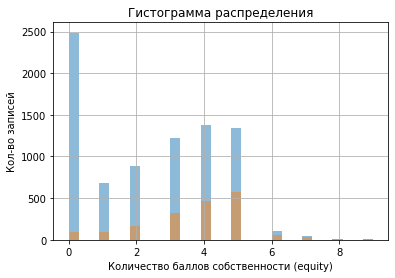

In [59]:
# посмотрим гистограмму распределения
df[df['churn'] == 0]['equity'].hist(bins=30, alpha=0.5)
df[df['churn'] == 1]['equity'].hist(bins=30, alpha=0.5)
plt.title('Гистограмма распределения')
plt.xlabel('Количество баллов собственности (equity)')
plt.ylabel('Кол-во записей');

In [60]:
# проверка с помощью теста Левена
# тест Левана с определением медианы

test_leven, p = st.levene(df[df['churn'] == 0]['equity'], df[df['churn'] == 1]['equity'], center='median')
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=414.577, p-value=0.000
Отклонить гипотезу о равенстве дисперсий


In [61]:
# проверка с помощью теста Левена
# тест Левана с определением среднего значения

test_leven, p = st.levene(df[df['churn'] == 0]['equity'], df[df['churn'] == 1]['equity'], center='mean')
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=485.342, p-value=0.000
Отклонить гипотезу о равенстве дисперсий


**Вывод:** Отклоняем гипотезу о равенстве дисперсий.

Установлено, что 2х выборок неравные дисперсии, приемним t-тест Уэлча. Он рассматривается как параметрический эквивалент T-теста с двумя выборками. Так же t-критерий Уэлча работает лучше, чем t-критерий Стьюдента, когда размеры выборки и дисперсии между группами не равны, и дает идентичные результаты, когда размеры выборки дисперсии равны.

In [62]:
# results = вызов метода для проверки гипотезы

results = st.ttest_ind (
    df[df['churn']==0]['equity'],
    df[df['churn']==1]['equity'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 
# условный оператор с выводом строки с ответом

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

2.2265321241808214e-196
Отвергаем нулевую гипотезу


**Вывод:** Отвергаем нулевую гипотезу. Средняя оценка баллов собственности оставшихся и отточных клиентов не равны; в целом ранее установлено, что более состоятельные клиенты (большее кол-во баллов собственности) более склонны к оттоку.

#### Гипотеза №3: Pазличие количества продуктов банка оставшихся и отточных клиентов

Сформулируем нулевые гипотезы:

    - H₀: среднее количество продуктов банка оставшихся и отточных клиентов равны
    - H₁: среднее количество продуктов банка оставшихся и отточных клиентов не равно

In [63]:
#посчитаем среднюю оценку для гипотезы №3
print('Средняя оценка по доходу клиентов не в оттоке', df[df['churn'] == 0]['products'].mean())
print('Средняя оценка по доходу клиентов в оттоке', df[df['churn'] == 1]['products'].mean())

Средняя оценка по доходу клиентов не в оттоке 1.7589209074187615
Средняя оценка по доходу клиентов в оттоке 2.3773377337733774


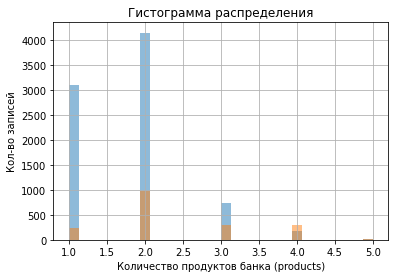

In [64]:
# посмотрим гистограмму распределения
df[df['churn'] == 0]['products'].hist(bins=30, alpha=0.5)
df[df['churn'] == 1]['products'].hist(bins=30, alpha=0.5)
plt.title('Гистограмма распределения')
plt.xlabel('Количество продуктов банка (products)')
plt.ylabel('Кол-во записей');

In [65]:
# проверка с помощью теста Левена
#тест Левана с определением среднего значения

test_leven, p = st.levene(df[df['churn'] == 0]['products'], df[df['churn'] == 1]['products'], center='mean')
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=267.305, p-value=0.000
Отклонить гипотезу о равенстве дисперсий


Установлено, что 2х выборок неравные дисперсии, приемним t-тест Уэлча. Он рассматривается как параметрический эквивалент T-теста с двумя выборками. Так же t-критерий Уэлча работает лучше, чем t-критерий Стьюдента, когда размеры выборки и дисперсии между группами не равны, и дает идентичные результаты, когда размеры выборки дисперсии равны.

In [66]:
# results = вызов метода для проверки гипотезы

results = st.ttest_ind (
    df[df['churn']==0]['products'],
    df[df['churn']==1]['products'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 
# условный оператор с выводом строки с ответом

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

1.2671065900765871e-138
Отвергаем нулевую гипотезу


**Вывод:** Отвергаем нулевую гипотезу. Среднее количество продуктов банка оставшихся и отточных клиентов не равно; в целом ранее установлено, что более состоятельные клиенты (большее кол-во баллов собственности) более склонны к оттоку.

#### Гипотеза №4: Pазличие количества кредитных карт банка оставшихся и отточных клиентов

Сформулируем нулевые гипотезы:

    - H₀: среднее количество кредитных карт банка оставшихся и отточных клиентов равны
    - H₁: среднее количество кредитных карт банка оставшихся и отточных клиентов не равно

In [67]:
#посчитаем среднюю оценку для гипотезы №4
print('Средняя оценка по доходу клиентов не в оттоке', df[df['churn'] == 0]['credit_card'].mean())
print('Средняя оценка по доходу клиентов в оттоке', df[df['churn'] == 1]['credit_card'].mean())

Средняя оценка по доходу клиентов не в оттоке 0.7088902513795218
Средняя оценка по доходу клиентов в оттоке 0.5517051705170517


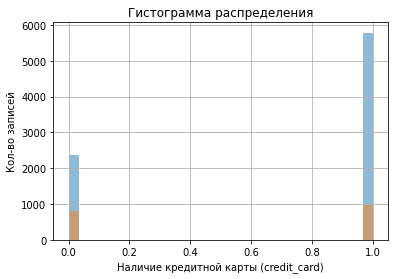

In [68]:
# посмотрим гистограмму распределения
df[df['churn'] == 0]['credit_card'].hist(bins=30, alpha=0.5)
df[df['churn'] == 1]['credit_card'].hist(bins=30, alpha=0.5)
plt.title('Гистограмма распределения')
plt.xlabel('Наличие кредитной карты (credit_card)')
plt.ylabel('Кол-во записей');

In [69]:
# проверка с помощью теста Левена
#тест Левана с определением среднего значения

test_leven, p = st.levene(df[df['churn'] == 0]['credit_card'], df[df['churn'] == 1]['credit_card'], center='mean')
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=333.226, p-value=0.000
Отклонить гипотезу о равенстве дисперсий


In [70]:
# проверка с помощью теста Левена
#тест Левана с определением медианы

test_leven, p = st.levene(df[df['churn'] == 0]['credit_card'], df[df['churn'] == 1]['credit_card'], center='median')
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=171.734, p-value=0.000
Отклонить гипотезу о равенстве дисперсий


**Вывод:** отклоняем гипотезу о равенстве дисперсий.

Так как распределение не явл.нормальным и размер выборки большой применим Z-тест 

In [71]:
# # применим z-тест
# def test_share_eq(dep_col, ind_col, ALPHA):
#     '''
#     Функция получает на вход названия колонки зависимого параметра (того чью долю считаем)
#     и независимого (того по которому группируем). Оба параметра должны быть булевы. Также
#     на вход идет уровень значимости теста, ALPHA.
    
#     Расчитывает необходимые доли и проводит Z-test на равенство долей с уровнем значимости ALPHA
    
#     Печатает ALPHA, p-value и результат теста.
#     '''
#     group_size = df[ind_col].value_counts() #размер групп
#     share_size = df.groupby(ind_col)[dep_col].sum() #размер целевых подгрупп в группах
   
    
#     p = share_size / group_size #доли
#     p_combined = share_size.sum() / group_size.sum() #общая доля
#     # разница пропорций в датасетах
#     difference = p[0] - p[1]
    
#     z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/group_size[0] + 1/group_size[1]))

#     # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
#     distr = st.norm(0, 1) 

#     p_value = (1 - distr.cdf(abs(z_value))) * 2

#     print(f'Уровень значимости: {ALPHA}')
#     print('p-значение: {0:.15f}'.format(p_value))

#     if (p_value < ALPHA):
#         print('Отклоняем нулевую гипотезу: среднее количество кредитных карт банка оставшихся и отточных клиентов равны')
#     else:
#         print('Не получилось отклонить нулевую гипотезу')

# test_share_eq('churn', 'credit_card', .05)

In [72]:
# применим z-тест
#определим размер групп
group_size = df['credit_card'].value_counts(sort=False) 

#определеим размер целевых подгрупп в группах
share_size = df.groupby('credit_card')['churn'].sum()

z_value, p_value = proportions_ztest(share_size, group_size)

test_leven, p = st.levene(df[df['churn'] == 0]['credit_card'], df[df['churn'] == 1]['credit_card'], center='median')
print('Statistics=%.3f, p-value=%.3f' % (z_value, p))
alpha = 0.05
if p < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

Statistics=12.995, p-value=0.000
Отвергаем нулевую гипотезу


In [73]:
# без округления
z_value

12.994601784943278

In [74]:
# без округления
p_value

1.3128935583367214e-38

**Вывод:** Отвергаем нулевую гипотезу. Как ранее было установлено в ходе анализа среди клиентов, ушедших в отток 71% пользователей кредитной картой, а среди оставшихся 55%.

### Выводы по этапу Исследовательский анализ данных (EDA)

<div style="border:solid green 2px; padding: 20px">
    
1) по количеству банковских продуктов:(top3)
   - 51% клиентов имеет 2 банковских продукта;
   - 33% клиентов имеет 1 банковский продукт;
   - 10% клиентов имеет 3 банковских продукта;
    
2) кредитная карта есть у 68% клиентов;
    
3) активность клиентов:
  - 52% активны;
  - 48% не активны;
    
4) **в отток ушло 18% клиентов**;
    
5) гендерное распределение среди клиентов 50/50;
    
6) распределение клиентов по городам: Ростов (14%), Рыбинск (27%), Ярославль (59%)
    
7) по географическому признаку: больше всего ушло клиентов из Ярославля (19,02%); Ростов (18,77%); Рыбинск (16,18%)


  *Общие данные*

|                        |products                          | credit card             |last_activity |
| ---------------------- | -------------------------------- |-------------------------|--------------|
|Отток (ушедшие клиенты) | 2 продукта (51%); 1 продукт (38%)|**имеют кред. карту 71%**|активны 48%   |
|Оставшиеся клиенты      | 2 продукта (54%); 1 продукт (13%)|имеют кред. карту 55%    |активны 70%   |


*Гендерное распределение*

|                        |female                    |  male                  |
| ---------------------- | ------------------------ |------------------------|
|Отток (ушедшие клиенты) |**53% жен среди ушедших** |47% муж среди ушедших   |
|Оставшиеся клиенты      |35% жен среди оставшихся  |65% муж среди оставшихся|


*Географическое распределение*

|                        |  Ярославль  |Ростов      |  Рыбинск |
|----------------------- | ------------| -----------|----------|
| Кол-во клиентов        |5 874        |1 417       |2 694     |
| Доля ушедших клиентов  |19.02%       |18.77%      |16.18%    |


*Результат анализа исследования распределения числовых признаков*

|           |Оставшиеся клиенты                                                  |  Отток (ушедшие клиенты)                                                   |
| ----------| ------------------------------------------------------------------ |----------------------------------------------------------------------------|
|score      |выходит на "плато" к 800 ед. больше всего в диапазоне от 800 до 950.| наблюдается пик на 850 - 870 ед. больше всего в диапазоне от 800 до 950.   |
|age        |больше всего клиентов от 35 до 45 лет                               | больше всего клиентов от 25-35, 37-45, 50-60                                      |
|equity     |больше всего клиентов с 0 кол-вом, далее 2й пик - 4 ед.             | среди ушедших клиентов больше всего состоятельных кол-вом баллов от 4 до 5 |
|balance    |много клиентов с небольшим балансом, вкл. пропуска, далее спад      | видимо у ушедших в отток больше всего пропусков                            |
|est_salary |нет сильного различия в уровне дохода у тех кто ушел в отток и тех, кто остался. гистограммы весьма схожи в обеих группах   

<div style="border:solid green 2px; padding: 20px">

*Выдвинутые и проверенные гипотезы:*
    
Гипотеза №1:
- H₀: средние доходы оставшихся и отточных клиентов равны (отвергаем);
- H₁: средние доходы оставшихся и отточных клиентов не равны;
    
Гипотеза №2:
- H₀: средняя оценка баллов собственности оставшихся и отточных клиентов равны (отвергаем);
- H₁: средняя оценка баллов собственности оставшихся и отточных клиентов не равны;
    
Гипотеза №3:
- H₀: среднее количество продуктов банка оставшихся и отточных клиентов равны (отвергаем);
- H₁: среднее количество продуктов банка оставшихся и отточных клиентов не равны;

Гипотеза №4:
- H₀: среднее количество кредитных карт банка оставшихся и отточных клиентов равны (отвергаем);
- H₁: среднее количество кредитных карт банка оставшихся и отточных клиентов не равны

## Сегментация

По итогам проведенного анализа и проверки гипотез выделим несколько высокоотточных сегментов клиентов банка. При этом в качестве критериев используем следующие параметры:

* пол ('gender') или прекодированные столбцы ('f', 'm');
* возраст ('age');
* количество баллов собственности ('equity');
* количество продуктов банка ('products');
* оценочный доход клиента ('est_salary');
* активность клиента ('last_acrtivity')

In [75]:
# напишем функцию для сегментации
def get_segment(row):
    result = [0, 0, 0]
    if row['male'] == 1 and row['balance']>= 80000:
        result[0]  = 1
    if row['products'] >= 2 and row['score']>= 700:
        result[1]  = 1
    if row['est_salary'] >= 50000 and row['last_activity'] == 1:
        result[2]  = 1
#     else:
#         return 'клиенты, не попавшие в сегментацию'
    return np.array(result)

In [76]:
df[['segment_1', 'segment_2', 'segment_3']] = np.vstack(df.apply(get_segment, axis=1))

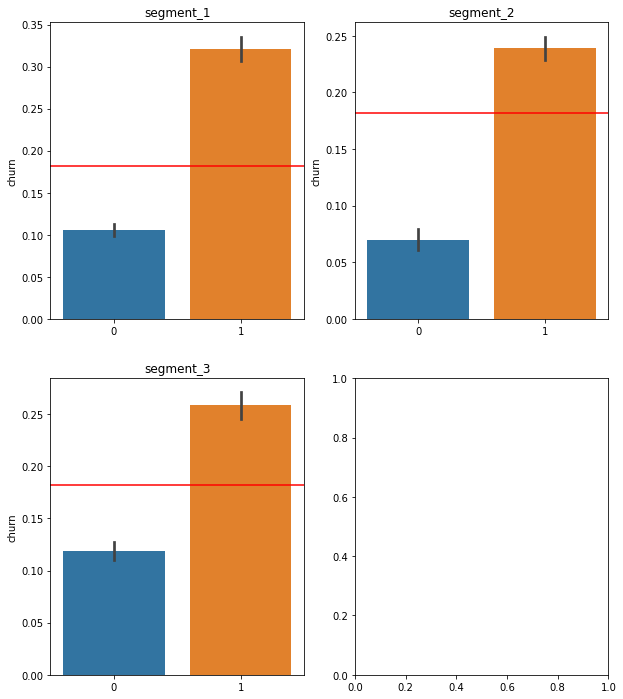

In [77]:
# Построим гистограммы чтобы посмотреть средний уровень оттока по сегментам
list_segment = [
    'segment_1', 'segment_2', 'segment_3' 
    ] 

rows = 2
fig, ax = plt.subplots(nrows=rows, ncols=2, figsize=(10, 12))
ax = ax.flatten()

for i in range(len(list_segment)):
    sns.barplot(x=df[list_segment[i]], y='churn', data=df, ax=ax[i])
    ax[i].axhline(y=df['churn'].mean(), c='red', label='Средний показатель оттока') 
    ax[i].set_title(f'{list_segment[i]}')
    ax[i].set_xlabel('')

plt.show()

**Вывод:** средний уровень оттока по сегментам выше, чем средний уровень оттока по банку в целом (18%) 

In [78]:
# посмотим кол-во клиентов банка в каждом сегменте
df[['segment_1', 'segment_2', 'segment_3']].sum(axis=0)

segment_1    3551
segment_2    6621
segment_3    4537
dtype: int64

In [79]:
# посмотрим средний отток в сегменте_1
df.loc[df['segment_1']==1, 'churn'].mean()

0.32075471698113206

In [80]:
# посмотрим средний отток в сегменте_2
df.loc[df['segment_2']==1, 'churn'].mean()

0.23908775109500074

In [81]:
# посмотрим средний отток в сегменте_3
df.loc[df['segment_3']==1, 'churn'].mean()

0.25854088604804937

**Вывод:** количество клиентов банка в сегментах более 500 человек, средний %оттока выше 18% (средний %оттока по банку)

### Приоритизация сегментов

Приоритезируем сегменты по мере убывания отточных клиентов:

1. Сегмент №1: 3 551 чел (мужчины с балансом на счету более 80 000) - 32,07 % оттока;
2. Сегмент №3: 4 537 чел (активные клиенты с оценочным доходом (зар.плата) более 50 000) - 25,85 % оттока;
3. Сегмент №2: 6 621 чел (клиенты банка имеющие более 2х продуктов банка и кредитный скоринг более 700) - 23,90 % оттока.

<div style="border:solid green 2px; padding: 20px">

## Рекомендации:

Сегмент 1: мужчины с балансом на счету более 80 000 (3 551 человек, 32,07 % оттока):
    
    - возможность самостоятельно выбирать категории кэшбэка (доплатить за выбор конткретной категории на месяц);    
    - среди программ лояльности предлагать больше автомобильной тематики (кэшбэк за бензин), программ связанных с недвижимостью;

    
Сегмент 3: активные клиенты с оценочным доходом (зар.плата) более 50 000 (4 537 человек, 25,85 % оттока):
    
    - более высокий % на накопительном счету; 
    - предложить выгодный перевод з/п в банк «Метанпромбанк» (в случае получения з/п в др. банке)
    - информировать о новых доступных банковских продуктах;
    
Сегмент 2: клиенты банка имеющие более 2х продуктов банка и кредитный скоринг более 700 (6 621 человек, 20,90 % оттока):
    
    - предложить специальные условия по страхованию объектов собственности (авто, недвижимость);    
    - кредитная карта с большей суммой кредита/более длительным сроком погашения кредита;
    - возможность самостоятельно выбирать категории кэшбэка (доплатить за выбор конткретной категории на месяц);
    - информировать о новых доступных банковских продуктах;
    